In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
engine.execute('select * from Measurement limit 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [13]:
engine.execute('select * from Station limit 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [14]:
print(dt.date.today())
year_ago = dt.date.today() - dt.timedelta(days=365)
print(year_ago)
session.query(Measurement.date).order_by(Measurement.date).first()


2019-11-21
2018-11-21


('2010-01-01')

In [15]:
last_data_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_data_point)

('2017-08-23',)


In [16]:
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [17]:
session.query(Measurement.prcp, Measurement.date > query_date).limit(10).all()

[(0.08, False),
 (0.0, False),
 (0.0, False),
 (0.0, False),
 (None, False),
 (0.06, False),
 (0.0, False),
 (0.0, False),
 (0.0, False),
 (0.01, False)]

# Exploratory Climate Analysis

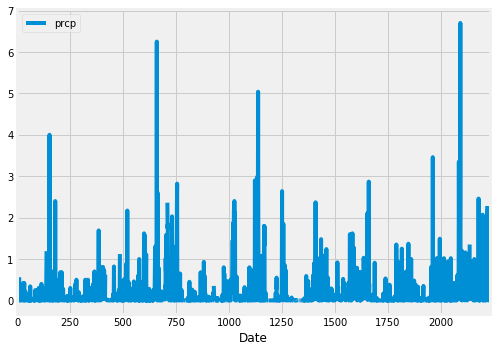

<Figure size 432x288 with 0 Axes>

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from
#the last data point in the database
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.prcp, Measurement.date > year_ago).limit(10).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
results = session.query(Measurement.date,Measurement.prcp).\
    order_by(Measurement.date.desc()).all()

# Sort the dataframe by date
summary_df = pd.DataFrame(results[:2230], columns=['date','prcp'])

# Use Pandas Plotting with Matplotlib to plot the data
summary_df.plot(figsize=(7,5))
plt.xlabel("Date")
plt.tight_layout()
plt.show()
plt.savefig('Images/Precipitation.png')

![precipitation](Images/precipitation.png)

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_df = pd.DataFrame(results[:2230], columns=['date','prcp'])
summary_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [20]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Measurement.station + Station.station).count()
print("There are a total of", total_stations, "stations in this data set")

There are a total of 175950 stations in this data set


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_sta = session.query(Measurement.station,func.count(Measurement.station)).\
                           group_by(Measurement.station).\
                            order_by(func.count(Measurement.station).desc()).all()
active_sta

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
max_min = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),
                       func.avg(Measurement.tobs)).\
                       filter(Measurement.station == 'USC00519281').order_by(func.min(Measurement.tobs)).all()
max_min

[(54.0, 85.0, 71.66378066378067)]

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temp = session.query(Measurement.tobs).\
            filter(Measurement.date>= year_ago, Measurement.station == "USC00519281").\
            order_by(Measurement.tobs).all()

year_temp_df = pd.DataFrame(year_temp, columns=["tobs"])
year_temp_df.head()

,tobs
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0


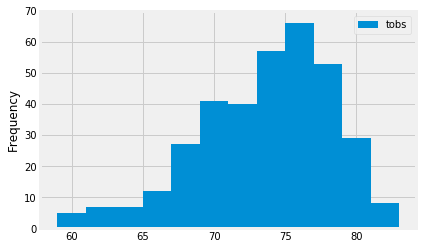

In [24]:
bins = 12
year_temp_df.plot.hist(year_temp,bins)
plt.ylim(0,70)
plt.savefig('Images/station-histogram.png')

![precipitation](Images/station-histogram.png)

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year_B = dt.date(2017, 8, 23) - dt.timedelta(days= 365)
# print(prev_year_start)
prev_year_E = prev_year_B + dt.timedelta(days = 5)
#print(prev_year_end)
calc_temp = calc_temps(prev_year_B, prev_year_E)
print(calc_temp)

[(71.0, 78.12820512820512, 84.0)]


In [50]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (prev_year_B): A date string in the format %Y-%m-%d
        end_date (prev_year_E): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= prev_year_B).filter(Measurement.date <= prev_year_E).all()

#print out the data from these dates
print(calc_temps('2017, 8, 23', '2017, 8, 28'))

[(71.0, 78.12820512820512, 84.0)]


In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_avg_temp = list(np.ravel(calc_temp))

tmin = trip_avg_temp[0]
tmax = trip_avg_temp[2]
temp_avg = trip_avg_temp[1]


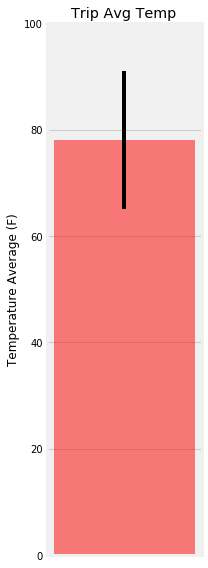

In [28]:
plt.figure(figsize=(3,8))
plt.bar(1,temp_avg, color = 'red',alpha = 0.5)
plt.errorbar(1,temp_avg, yerr=(tmax - tmin), color = 'black')
plt.ylim(0, 100)
plt.xticks([])
plt.title('Trip Avg Temp')
plt.ylabel("Temperature Average (F)")
plt.tight_layout()

In [44]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_sta = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,
                            func.sum(Measurement.prcp)).\
filter(Measurement.station == Station.station).\
filter(Measurement.date >= prev_year_B, Measurement.date <= prev_year_E).\
filter(Measurement.prcp != None).\
        group_by(Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()


print(rainfall_sta)

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 4.7299999999999995), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 4.33), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.73), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 2.51), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 1.5899999999999999), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.17), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.04)]


## Optional Challenge Assignment

In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [32]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [33]:
# Plot the daily normals as an area plot with `stacked=False`
